# 1. Import Necessary Libraries

In [ ]:
# Install necessary packages
!pip install snowflake-connector-python
!pip install snowflake-sqlalchemy
!pip install sqlalchemy
!pip install pandas
!pip install xgboost
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/snowflake/sqlalchemy/base.py:1068: SAWarning: The GenericFunction 'flatten' is already registered and is going to be overridden.
  functions.register_function("flatten", flatten)


# 2. Connect to Snowflake and Load Data

In [ ]:
ACCOUNT = <account>
USER = <user>
PASSWORD = <password>
WAREHOUSE = <warehouse>
DATABASE = <database>
SCHEMA = <schema>

# Create connection URL
engine = create_engine(URL(
    account=ACCOUNT,
    user=USER,
    password=PASSWORD,
    warehouse=WAREHOUSE,
    database=DATABASE,
    schema=SCHEMA,
))

# Create a connection
connection = engine.connect()

# Load data into pandas DataFrames
customers = pd.read_sql_query("SELECT * FROM customer_demographic", connection)
prospective_buyers = pd.read_sql_query("SELECT * FROM prospect_demographic", connection)

# Close the connection
connection.close()

In [ ]:
customers.head()

,age,maritalstatus,gender,yearlyincome,totalchildren,numberchildrenathome,education,occupation,houseownerflag,numbercarsowned,country,segment
0,43,M,M,90000,2,0,Bachelors,Professional,1,0,Australia,Best Customers
1,38,S,M,60000,3,3,Bachelors,Professional,0,1,Australia,Best Customers
2,43,M,M,60000,3,3,Bachelors,Professional,1,1,Australia,Best Customers
3,41,S,F,70000,0,0,Bachelors,Professional,0,1,Australia,Best Customers
4,35,S,F,80000,5,5,Bachelors,Professional,1,4,Australia,Best Customers


In [ ]:
prospective_buyers.head()

,prospectivebuyerkey,age,maritalstatus,gender,yearlyincome,totalchildren,numberchildrenathome,education,occupation,houseownerflag,numbercarsowned,city,stateprovincecode
0,1,69,M,M,40000,3,0,Partial Co,Professional,1,2,Cedar City,UT
1,2,64,M,F,80000,4,0,Bachelors,Management,1,2,Colma,CA
2,3,50,S,M,130000,3,4,Partial Co,Professional,1,4,Lynnwood,WA
3,4,29,S,M,50000,0,0,Partial Co,Skilled Manual,1,2,Chula Vista,CA
4,5,49,M,F,10000,2,0,Partial Co,Manual,1,0,Dallas,TX


# 3. Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import euclidean_distances

# Assuming dim_customers and fact_prospective_buyers DataFrames are already loaded

# Define the feature columns (including categorical and numerical ones)
features = [
    'age', 'maritalstatus', 'gender', 'yearlyincome','totalchildren',
    'numbercarsowned', 'education', 'occupation', 'houseownerflag',
    'numberchildrenathome'
]

# Separate numerical and categorical features
numerical_features = ['yearlyincome', 'totalchildren', 'numberchildrenathome',
                      'houseownerflag', 'numbercarsowned', 'age']
categorical_features = ['maritalstatus', 'gender','education', 'occupation']

# Fix known typos or abbreviations in prospective_buyers
prospective_buyers['education'].replace({
    'Graduate D': 'Graduate Degree',
    'High Schoo': 'High School',
    'Partial Co': 'Partial College',
    'Partial Hi': 'Partial High School'
}, inplace=True)

# Preprocessing pipeline: scale numerical features, and one-hot encode categorical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Apply the transformation to both labeled and unlabeled datasets
X_labeled = customers[features]
X_unlabeled = prospective_buyers[features]

# Fit the preprocessor pipeline to the labeled data
X_labeled_transformed = preprocessor.fit_transform(X_labeled)

# Transform the unlabeled data using the same pipeline
X_unlabeled_transformed = preprocessor.transform(X_unlabeled)

# Get the labeled segments (target variable)
y_labeled = customers['segment']

# Create a DataFrame from the transformed labeled data to group by segment
X_labeled_df = pd.DataFrame(X_labeled_transformed.toarray() if hasattr(X_labeled_transformed, 'toarray') else X_labeled_transformed)

# 4. Calculate the Centroid for Each Segment

In [ ]:
# Calculate the centroid of each segment by taking the mean of each feature for each segment
centroids = X_labeled_df.groupby(y_labeled).mean()

# Ensure that both labeled and prospective buyer datasets are aligned after transformation
X_unlabeled_df = pd.DataFrame(X_unlabeled_transformed.toarray() if hasattr(X_unlabeled_transformed, 'toarray') else X_unlabeled_transformed)

# Calculate the distances between each prospective buyer and each segment centroid
distances = euclidean_distances(X_unlabeled_df, centroids)

# Assign the nearest cluster (segment) to each prospective buyer based on the closest centroid
closest_segments = centroids.index[distances.argmin(axis=1)]

# Add the predicted closest segment back to the prospective buyers DataFrame
prospective_buyers['predicted_segment'] = closest_segments

# Summarize the predicted segments by count
segment_summary = prospective_buyers['predicted_segment'].value_counts()

# Display the summary of predicted segments
print("Summary of predicted segments (counts):")
print(segment_summary)

Summary of predicted segments (counts):
predicted_segment
Loyal Customers    700
Other              694
Best Customers     400
At Risk            265
Name: count, dtype: int64


#  5. Visualization

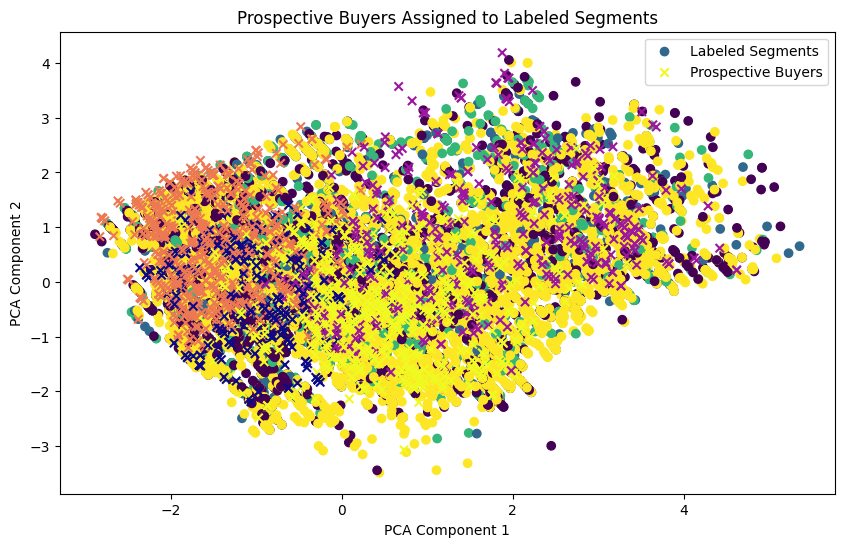

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Step 1: Reduce to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
X_labeled_pca = pca.fit_transform(X_labeled_transformed)
X_unlabeled_pca = pca.transform(X_unlabeled_transformed)

# Step 2: Encode the segment labels into numeric values for plotting
label_encoder = LabelEncoder()

# Encode the labeled data segments
y_labeled_encoded = label_encoder.fit_transform(y_labeled)

# Encode the predicted segments for prospective buyers
prospective_buyers['predicted_segment_encoded'] = label_encoder.transform(prospective_buyers['predicted_segment'])

# Step 3: Plot the PCA-transformed data
plt.figure(figsize=(10, 6))

# Plot the labeled customer segments (centroids as cluster centers)
plt.scatter(X_labeled_pca[:, 0], X_labeled_pca[:, 1], c=y_labeled_encoded, cmap='viridis', label='Labeled Segments')

# Plot the prospective buyers assigned to segments
plt.scatter(X_unlabeled_pca[:, 0], X_unlabeled_pca[:, 1], c=prospective_buyers['predicted_segment_encoded'], cmap='plasma', marker='x', label='Prospective Buyers')

# Add title and labels
plt.title('Prospective Buyers Assigned to Labeled Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Display legend
plt.legend()
plt.show()